# 1. Feature extraction from images

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = r'/content/drive/MyDrive/EuroSat/EuroSAT'

In [ ]:
pip install mahotas

In [ ]:
import cv2
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
import pandas as pd
import mahotas
import os
import random

## Extractor de HoG, HISTC, HuM, HarT

In [ ]:
path_images =  r'/content/drive/MyDrive/EuroSat/EuroSAT'

In [ ]:
folders = sorted([d for d in os.listdir(path_images) if os.path.isdir(os.path.join(path_images,d))])
print(folders)
fixed_size = (64, 64)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


27000


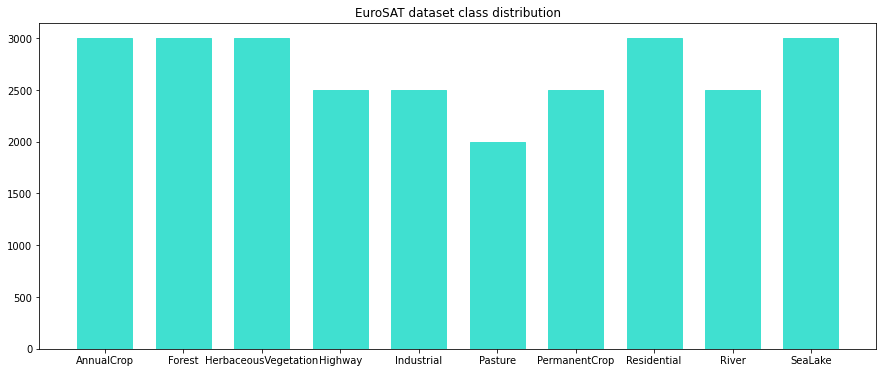

In [ ]:
def count_labels(clases, path):
    n_img =[]
    for i, rock in enumerate(clases):
        pathi = os.path.join(path,rock)
        n_img.append(len(os.listdir(pathi)))
    #print(n_img)
    labels = []
    for i in range(len(clases)):
        labels.append([clases[i]]*n_img[i])
    ylabels = labels[0]
    for i in range(1,len(labels)):
        ylabels += labels[i]
    return ylabels, n_img

def histograma(ylabels, clases, title, color="goldenrod"):
    #histogramas de las categorias de las imágenes 
    plt.figure(figsize=(15,6))
    a = np.array(ylabels)
    plt.hist(a, bins=np.arange(-0.5,len(clases)+0.5,1.0), rwidth=0.7, color=color, ec=color)
    plt.title(title)
    plt.show()

ylabels, n_img = count_labels(folders, path_images)
ntrain = np.sum(n_img)
print(ntrain)
histograma(ylabels, folders,"EuroSAT dataset class distribution", color="turquoise")

In [ ]:
def fd_hog(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # calculate the hog and return a visual representation.
  H= hog(
    image, pixels_per_cell=(6, 6),
    cells_per_block=(2,2),
    orientations=8,
    visualize=False,
    block_norm='L2-Hys')
  return H

In [ ]:
# descriptor de rasgos: Momentos Hu 
def fd_hu_moments(image):
  # convertir imagen en escala de grises
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # calculo del vector de rasgos de momentos Hu
  feature = cv2.HuMoments(cv2.moments(image)).flatten()
  return feature

In [ ]:
# descriptor de rasgos: Haralick Texture
def fd_haralick(image):
  # convertir imagen en escala de grises
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # calculo del vector de rasgos de textura haralick
  haralick = mahotas.features.haralick(gray).mean(axis=0)
  return haralick

In [ ]:
# descriptor de rasgos: Histograma de color
def fd_histogram(image, mask=None, bins=8):
  # conversión de la imagen al espacio de color HSV
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  # calculo del histograma de color
  hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
  # normalización del histograma
  cv2.normalize(hist, hist)
  return hist.flatten()

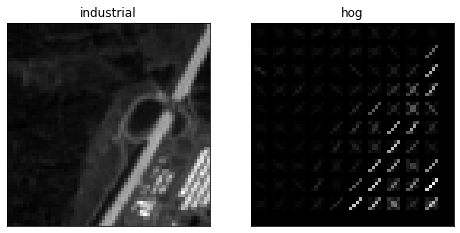

(2592,)
[ 5.18039138e-01  1.19059350e-03  1.20241642e-03  3.39932720e-03
 -1.34159167e-06  1.05002214e-04 -6.74031579e-06]
number of pixels: 64, 64
number of hog features:  2592


In [ ]:
imagen = imread(r'/content/drive/MyDrive/EuroSat/EuroSAT/Highway/Highway_100.jpg', as_gray=True)
 
# scale down the image to one third
#imagen = rescale(imagen, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
imagen_hog, imagen_hog_img = hog(
    imagen, pixels_per_cell=(6, 6),
    cells_per_block=(2,2),
    orientations=8,
    visualize=True,
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for a in ax]
 
ax[0].imshow(imagen, cmap='gray')
ax[0].set_title('industrial')
ax[1].imshow(imagen_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

print(imagen_hog.shape)
cv2.HuMoments(cv2.moments(imagen)).flatten()
print(cv2.HuMoments(cv2.moments(imagen)).flatten())
print('number of pixels: %s, %s'%(imagen.shape[0], imagen.shape[1]))
print('number of hog features: ', imagen_hog.shape[0])

In [ ]:
64*64*3

12288

In [ ]:
ind_train=[]
hist = ["histogram_%s"%i for i in range(512)]
hal = ["hal_%s"%i for i in range(13)]
hum = ["hum_%s"%i for i in range(7)]
hogs = ["hog_%s"%i for i in range(2592)]
cols = hist + hal+ hum + hogs + ['label']
ind_train = [i for i in range(ntrain)]

df = pd.DataFrame(columns = cols,index=ind_train) 
print(df.shape)

(27000, 3125)


In [ ]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [ ]:
def global_features(df,path,labels):
  ac=0
  for name in labels:
    # directorio de la clase
    dirc = os.path.join(path, name)
    # nombre de la clase actual
    current_label = name
    #print(current_label)
    images = os.listdir(dirc)
    images.sort(key=natural_keys)
    # ciclo sobre cada imagen
    for image_name in images:
      # path de la imagen
      fileim = os.path.join(dirc,image_name)
      # lectura y redimensionar la imagen
      image = cv2.imread(fileim)
      #image = cv2.resize(image, fixed_size)
      ####################################
      # Extraccion de rasgos globales
      ####################################
      fv_hu_moments = fd_hu_moments(image)
      fv_haralick   = fd_haralick(image)
      fv_histogram  = fd_histogram(image)
      fv_hog  = fd_hog(image)
      ###################################
      # Concatenacion de rasgos
      ###################################
      linea = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, fv_hog, current_label])
      # agrega linea al dataframe vacío 
      df.iloc[ac] = linea
      ac+=1
      if ac%500==0:
        print("Terminó: %s"%fileim)
    print("Folder procesado: {}".format(current_label))
  print("Extracción de rasgos globales completa")

In [ ]:
global_features(df, path, folders)

Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/AnnualCrop/AnnualCrop_500.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/AnnualCrop/AnnualCrop_1000.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/AnnualCrop/AnnualCrop_1500.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/AnnualCrop/AnnualCrop_2000.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/AnnualCrop/AnnualCrop_2500.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/AnnualCrop/AnnualCrop_3000.jpg
Folder procesado: AnnualCrop
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/Forest/Forest_500.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/Forest/Forest_1000.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/Forest/Forest_1500.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/Forest/Forest_2000.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/Forest/Forest_2500.jpg
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/Forest/Forest_3000.jpg
Folder procesado: Forest
Terminó: /content/drive/MyDrive/EuroSat/EuroSAT/

In [ ]:
df.to_csv(os.path.join(path,'EUROSAT_LOC_GLOB_skim.csv'), index=False)